# How to measure the overall quality of mobile applications

In [887]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.parser import parse
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle
from sklearn import svm
from sklearn import preprocessing
from xgboost import XGBClassifier
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.models import Axis, HoverTool as hover


plt.style.use('ggplot')
output_notebook()

Loading BokehJS ...

In [660]:
# Load the datasets
table = pd.read_csv('googleplaystore.csv')
review = pd.read_csv('googleplaystore_user_reviews.csv')

## Data Preprocessing

In [661]:
table.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


#### Drop 'Size' and 'Current Ver' because these are not meaningful features in this analysis.

In [662]:
table  = table.drop(['Size', 'Current Ver'], axis=1)

#### 'Category' and 'Genres' contain similar information. Let's see if we can drop the one of two columns.

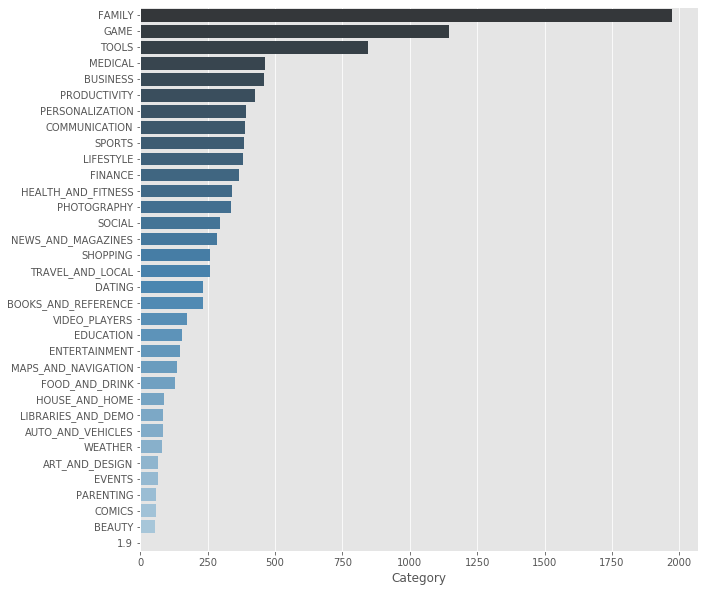

In [663]:
# Count by 'Category'
plt.figure(figsize=(10,10))
sns.barplot(x=table['Category'].value_counts(), y=table['Category'].value_counts().index, palette='Blues_d')
plt.show()

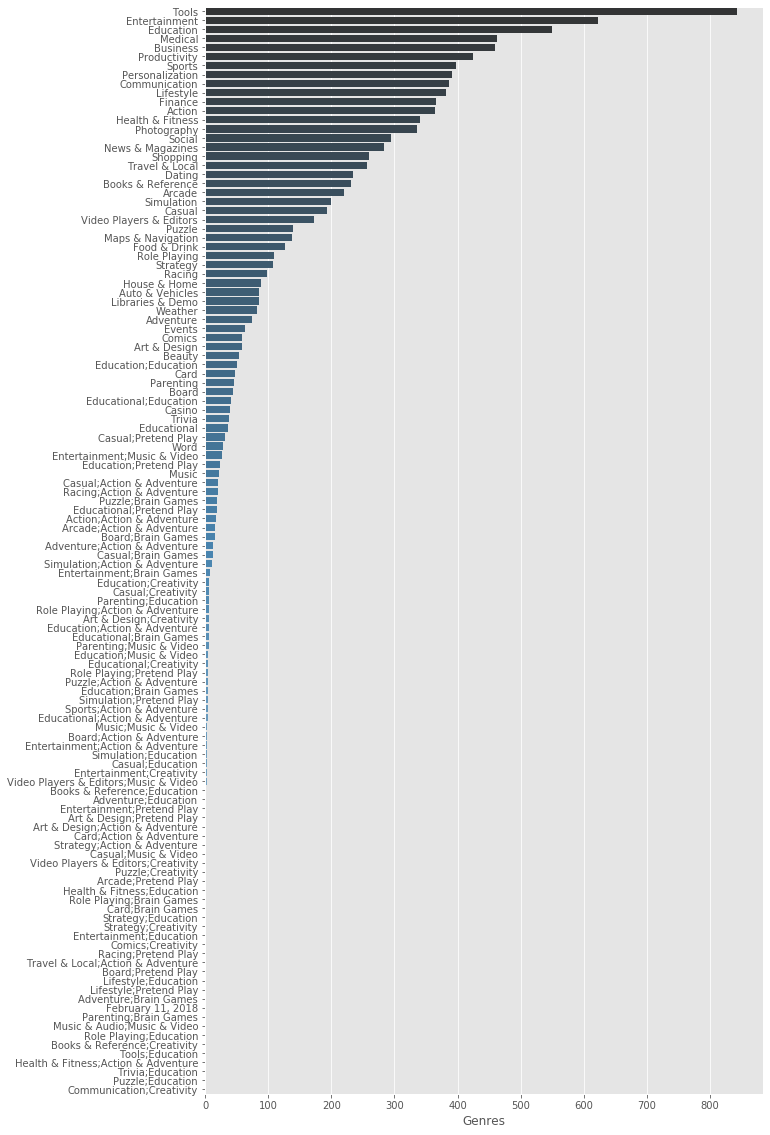

In [664]:
# Count by Genres
plt.figure(figsize=(10, 20))
sns.barplot(x=table['Genres'].value_counts(), y=table['Genres'].value_counts().index, palette='Blues_d')
plt.show()

#### 'Genres' is more specific about what are the applications about, but there are many genres that have very little data points. Therefore, it might be difficult to get insights about its attribute.
#### On the other hand, 'Category' is less detail in segmenting applications but it is a better feature than 'Genres' because it is less complex. Moreover, there are enough data points in every category. (It has an abnormal data '1.9', and this will resolve along the analysis)
#### Dropping 'Genres' is a better choice in this analysis.

In [665]:
table = table.drop('Genres', axis=1)

In [666]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 10 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Last Updated      10841 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(9)
memory usage: 847.0+ KB


#### In 'Rating', there are many NaN values (9367 out of 10841, 86%).

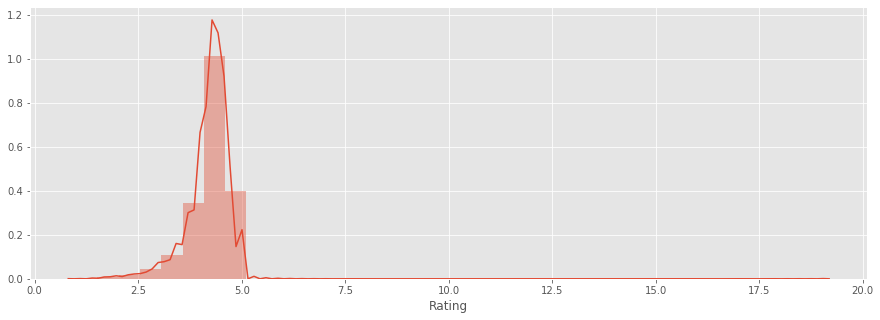

In [667]:
plt.figure(figsize=(15, 5))
sns.distplot(table['Rating'].dropna(), bins=35)
plt.show()

#### It seems there is an abnormal data point. The maximum rating that an application can have is 5 but there is a higher value based on the plot above.

In [668]:
table['Rating'].sort_values(ascending=False).head(10)

10472    19.0
7435      5.0
8058      5.0
8234      5.0
8230      5.0
5450      5.0
9455      5.0
8159      5.0
8146      5.0
5482      5.0
Name: Rating, dtype: float64

In [669]:
table[table['Rating'] == table['Rating'].max()]

,App,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Last Updated,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,Free,0,Everyone,NaN,1.0.19,NaN


#### It looks like it's a mistake in data entry. Everything is pushed left from 'Category to 'Android Ver'.

#### Getting information about the application from Google Play Store website:
<img src='img/Screen Shot 2019-12-02 at 3.40.36 AM.png' width="500">

In [670]:
# Fixing the data
table.iloc[10472] = table.iloc[10472].replace(['1.9', 19, '3.0M', 'Free', '0', 'Everyone', 'February 11, 2018', '1.0.19'], \
                                              ['LIFESTYLE', 2.5, 32, '5,000+', 'Free', 0, 'Lifestyle', 'February 11, 2018'])
table.iloc[10472] =table.iloc[10472].replace({'Content Rating': None}, 'Everyone')
table.iloc[10472] =table.iloc[10472].replace({'Android Ver': None}, '1.0.19')

table.iloc[10472]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                        LIFESTYLE
Rating                                                2.5
Reviews                                                32
Installs                                           5,000+
Type                                                 Free
Price                                                   0
Content Rating                                   Everyone
Last Updated                            February 11, 2018
Android Ver                                        1.0.19
Name: 10472, dtype: object

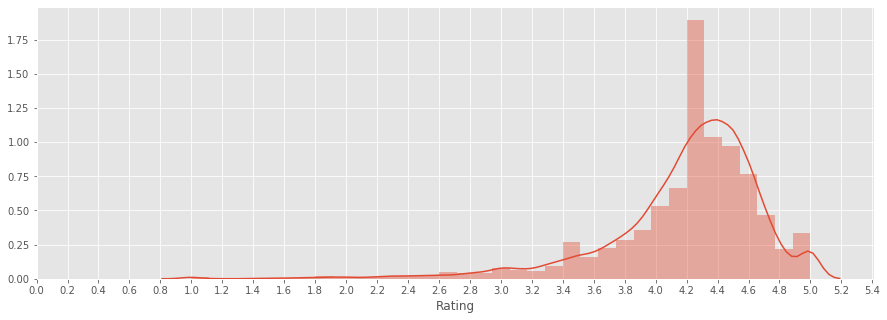

In [671]:
plt.figure(figsize=(15, 5))
sns.distplot(table['Rating'].dropna(), bins=35)
plt.xticks(np.arange(0, 5.5, step=0.2))
plt.show()

In [672]:
print('', 'Mean: {}'.format(round(table['Rating'].mean(),1)), '\n', \
      'Mode: {}'.format(table['Rating'].mode()[0]), '\n', \
      'Median: {}'.format(table['Rating'].median()))

 Mean: 4.2 
 Mode: 4.4 
 Median: 4.3


#### It would be more relevant to replace with mean, mode, or median within a same category and similar feature values than replace with overall mean, mode, or median.

In [673]:
cat_rating = []
for i in range(len(table['Category'].value_counts())):
    cat_rating.append([table['Category'].value_counts().index[i], \
                              round(table[table['Category'] == table['Category'].value_counts().index[i]]['Rating'].dropna().mean(), 1), \
                              table[table['Category'] == table['Category'].value_counts().index[i]]['Rating'].dropna().mode()[0], \
                              table[table['Category'] == table['Category'].value_counts().index[i]]['Rating'].dropna().median()])

cat_rating = pd.DataFrame(cat_rating, columns=['Category', 'Mean', 'Mode', 'Median'])
cat_rating    

,Category,Mean,Mode,Median
0,FAMILY,4.2,4.3,4.3
1,GAME,4.3,4.5,4.4
2,TOOLS,4.0,4.2,4.2
3,MEDICAL,4.2,4.5,4.3
4,BUSINESS,4.1,4.4,4.3
5,PRODUCTIVITY,4.2,4.4,4.3
6,PERSONALIZATION,4.3,4.5,4.4
7,COMMUNICATION,4.2,4.3,4.3
8,SPORTS,4.2,4.4,4.3
9,LIFESTYLE,4.1,5.0,4.2


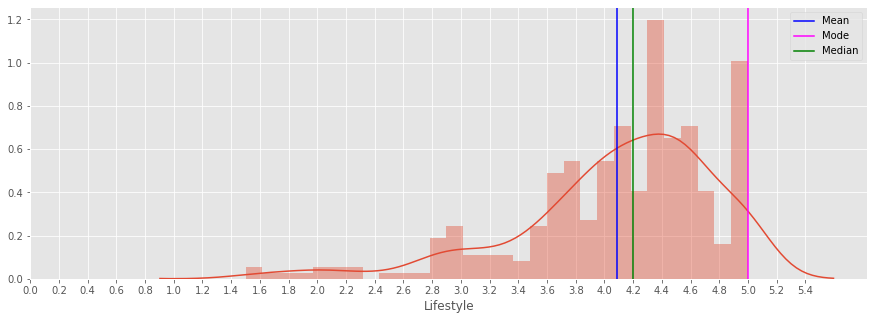

In [767]:
plt.figure(figsize=(15, 5))
sns.distplot(table[table['Category'] == 'LIFESTYLE']['Rating'].dropna(), bins=30)
plt.axvline(table[table['Category'] == 'LIFESTYLE']['Rating'].dropna().mean(), color='blue', label='Mean')
plt.axvline(table[table['Category'] == 'LIFESTYLE']['Rating'].dropna().mode()[0], color='magenta', label='Mode')
plt.axvline(table[table['Category'] == 'LIFESTYLE']['Rating'].dropna().median(), color= 'green', label='Median')
plt.xticks(np.arange(0, 5.5, step=0.2))
plt.xlabel('Lifestyle')
plt.legend(loc=0)
plt.show()

#### Change the data to proper data types for futher analysis about how other features affect on Rating.

In [676]:
table['Installs'] = table['Installs'].str.replace(',', '')
table['Installs'] = table['Installs'].str.replace('+', '')

table['Last Updated'] = pd.to_datetime(table['Last Updated'],format='%B %d, %Y')
table['Android Ver'] = table['Android Ver'].str.replace('and up', '')
table['Price'] = table['Price'].str.replace('$', '')

table = table.astype({'Category':'category', 'Reviews': 'int', 'Installs': 'int','Type': 'category','Price': 'float'})
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 10 columns):
App               10841 non-null object
Category          10841 non-null category
Rating            9367 non-null float64
Reviews           10841 non-null int64
Installs          10841 non-null int64
Type              10840 non-null category
Price             10840 non-null float64
Content Rating    10841 non-null object
Last Updated      10841 non-null datetime64[ns]
Android Ver       10839 non-null object
dtypes: category(2), datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 700.4+ KB


In [748]:
# Subset the Reviews that are match with Ratings' indexes
rating_wo_null = table['Rating'].dropna()

reviews_wrating = []
for i in rating_wo_null.index:
    reviews_wrating.append(table['Reviews'][i])    
    
installs_wrating = []
for i in rating_wo_null.index:
    installs_wrating.append(table['Installs'][i])    
    
rating_wo_null = rating_wo_null.reset_index(drop=True)

In [889]:
hover.tooltips = [
    ('(x,y)', '($x,$y)'),
    ('Reviews', '@Reviews')
]

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,\
        box_zoom,undo,redo,reset,tap,save,box_select,lasso_select,"

p = figure(title='Test', tools=TOOLS)
p.xaxis.axis_label = 'Rating'
p.yaxis.axis_label = 'Reviews'
p.left[0].formatter.use_scientific = False

p.circle(rating_wo_null, reviews_wrating, fill_alpha=0.2, size=8)
show(p)

In [867]:
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,\
        box_zoom,undo,redo,reset,tap,save,box_select,lasso_select,"

p = figure(title='Test', tools=TOOLS)
p.xaxis.axis_label = 'Rating'
p.yaxis.axis_label = 'Installs'
p.left[0].formatter.use_scientific = False

p.circle(rating_wo_null, installs_wrating, fill_alpha=0.2, size=8)
show(p)

#### According to plots above, we can see that when number of reviews or installs are higher than a certain point, the varience of Rating is not big.